# Predicting Apple Stock Price Movement Trends - Classification Model 
Author: Nishaal Ajmera

In [82]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import math

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

### Getting the Data

Text(0, 0.5, 'Close Price (USD)')

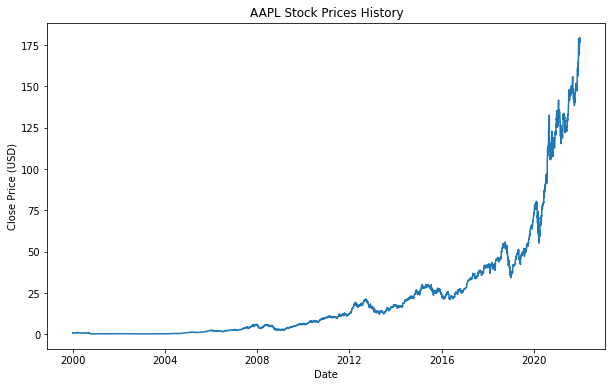

In [83]:
# Select ticker - Apple Ticker 
ticker = 'AAPL'
start = dt.datetime(2000,1,1)
end = dt.datetime(2022,1,1)

ticker_instance = yf.Ticker(ticker)
stock_data = ticker_instance.history(start = start, end = end)

# Plot chart for historical close prices for selected range 
plt.figure(figsize=(10, 6))
plt.title(f"{ticker} Stock Prices History")
plt.plot(stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')

In [84]:

# Setup target - if the price will go up or down (directionality)
stock_data["Tomorrow"] = stock_data["Close"].shift(-1)

# is tomorrows price greater than todays price
stock_data["Target"] = (stock_data["Tomorrow"] > stock_data["Close"]).astype(int)

stock_data.head()


,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target
Date,,,,,,,,,
2000-01-03,0.799515,0.857644,0.775215,0.853356,535796800,0.0,0.0,0.781409,0
2000-01-04,0.825244,0.843349,0.771403,0.781409,512377600,0.0,0.0,0.792844,1
2000-01-05,0.790938,0.842873,0.785221,0.792844,778321600,0.0,0.0,0.724232,0
2000-01-06,0.809044,0.815714,0.724232,0.724232,767972800,0.0,0.0,0.758538,1
2000-01-07,0.735668,0.769974,0.728045,0.758538,460734400,0.0,0.0,0.745197,0


### Model 1 - Random Forest with selected predictors

In [85]:
# Prepare train and test data
training_data_len = math.ceil(len(stock_data)* 0.8)
train_data = stock_data[0: training_data_len]
test_data = stock_data[-training_data_len:]


predictors = ["Close","Volume","Open","High","Low"]

# Model 
model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)
model.fit(train_data[predictors],train_data["Target"])

# Test Model 
preds = model.predict(test_data[predictors])
preds = pd.Series(preds, index = test_data.index)

# Evaluation metric 
print("1. Normal Random forest Precision:", precision_score(test_data["Target"], preds))


1. Normal Random forest Precision: 0.7314504547630445


### Model 2 - Random Forest with back testing 

In [86]:
# Back test model 
# prediction functions

def predict(train,test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index = test.index, name= "Predictions")
    combined = pd.concat([test["Target"],preds], axis =1)
    return combined


def backtest(data, model, predictors, start = 2500, step = 250):
    all_predictions = [] # list of dataframes

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions) # concatenate various dataframes


predictions = backtest(stock_data, model, predictors)
print("2. Backtest Random forest model Precision:",precision_score(predictions["Target"], predictions["Predictions"]))

2. Backtest Random forest model Precision: 0.5194805194805194


### Model 3 - Random Forest with close ratio over moving averages across 5 time horizons 

In [87]:
# Back test model with moving averages 
# get moving averages across different time horizons and calculate ratio
horizons = [2, 5, 60, 250, 1000] # no of trading days
new_predictors = []

for horizon in horizons:
    rolling_averages = stock_data.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    stock_data[ratio_column] = stock_data["Close"]/rolling_averages["Close"]

    trend_column = f"Trend_{horizon}" # days stock prices went up within horizon (exc current day)
    stock_data[trend_column] = stock_data.shift(1).rolling(horizon).sum()["Target"] # shift forward

    new_predictors += [ratio_column, trend_column]

# remove missing values
stock_data = stock_data.dropna()

stock_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,,,
2003-12-26,0.310277,0.318815,0.310124,0.316832,103695200,0.0,0.0,0.322474,1,1.008983,2.0,1.033316,3.0,0.951842,28.0,1.123531,129.0,0.801992,471.0
2003-12-29,0.318815,0.322626,0.318052,0.322474,233458400,0.0,0.0,0.324456,1,1.008825,2.0,1.036766,4.0,0.968363,29.0,1.141854,129.0,0.817223,472.0
2003-12-30,0.322931,0.327811,0.322474,0.324456,204853600,0.0,0.0,0.325828,1,1.003063,2.0,1.028715,4.0,0.974619,29.0,1.147266,129.0,0.823222,472.0
2003-12-31,0.325523,0.328268,0.322931,0.325828,174451200,0.0,0.0,0.324456,0,1.002110,2.0,1.017716,5.0,0.979429,29.0,1.150513,129.0,0.827540,473.0
2004-01-02,0.328572,0.331622,0.322931,0.324456,144642400,0.0,0.0,0.338026,1,0.997890,1.0,1.005101,4.0,0.976752,28.0,1.144096,129.0,0.824965,472.0


In [88]:
# increase estimator and reduce min samples split
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state = 1)

def predict(train,test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] # returns a probability
    preds[preds >= 0.6] = 1
    preds[preds < 0.6] = 0 # change default threshold to 60%
    preds = pd.Series(preds, index = test.index, name= "Predictions")
    combined = pd.concat([test["Target"],preds], axis =1)
    return combined

# use more informative columns - ratios rather than absolutes
predictions = backtest(stock_data, model, new_predictors)

print("3. Backtest Random forest model with additional features Precision:", precision_score(predictions["Target"], predictions["Predictions"]))

3. Backtest Random forest model with additional features Precision: 0.5377969762419006
